## Summary

---

## Imports

In [1]:
import concurrent.futures
import io
import json
import sys
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from IPython.display import SVG, Image, display
from scipy import stats
from sklearn import metrics, model_selection
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from tqdm.auto import tqdm

In [2]:
pd.set_option("max_rows", 1000)
pd.set_option("max_columns", 1000)
pd.set_option("display.max_colwidth", 120)

## Parameters

In [3]:
NOTEBOOK_DIR = Path("45_validate_models").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/lustre07/scratch/strokach/workspace/elaspic2-cagi6/notebooks/45_validate_models')

In [4]:
src_dir = str(NOTEBOOK_DIR.parents[1].joinpath("src"))
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

import helpers

## Load results

In [5]:
input_file_1 = NOTEBOOK_DIR.parent.joinpath(
    "37_cagi6_sherloc_combine_results", "combined-results.parquet"
)

input_file_2 = NOTEBOOK_DIR.parent.joinpath(
    "37_humsavar_combine_results", "combined-results.parquet"
)

input_file_1, input_file_2

(PosixPath('/lustre07/scratch/strokach/workspace/elaspic2-cagi6/notebooks/37_cagi6_sherloc_combine_results/combined-results.parquet'),
 PosixPath('/lustre07/scratch/strokach/workspace/elaspic2-cagi6/notebooks/37_humsavar_combine_results/combined-results.parquet'))

In [6]:
result_1_df = pq.read_table(input_file_1).to_pandas()
result_2_df = pq.read_table(input_file_2).to_pandas()

In [7]:
result_1_df["protein_id"].isnull().sum()

546

In [8]:
result_1_df = result_1_df.dropna(subset=["protein_id"])

In [9]:
common_columns = set(result_1_df) & set(result_2_df)
mismatched_columns = set(result_1_df) ^ set(result_2_df)

len(common_columns), len(mismatched_columns)

(110, 17)

In [10]:
mismatched_columns

{'alphafold_core_features_aligned_confidence_probs_col_max',
 'alphafold_core_features_aligned_confidence_probs_col_mean',
 'alphafold_core_features_aligned_confidence_probs_diag',
 'alphafold_core_features_aligned_confidence_probs_row_max',
 'alphafold_core_features_aligned_confidence_probs_row_mean',
 'alphafold_core_score_msa_logits_first_change',
 'alphafold_core_score_msa_logits_first_wt',
 'alphafold_core_score_msa_logits_max_change',
 'alphafold_core_score_msa_logits_max_wt',
 'alphafold_core_score_msa_logits_mean_change',
 'alphafold_core_score_msa_logits_mean_wt',
 'alphafold_core_score_predicted_aligned_error_col_max',
 'alphafold_core_score_predicted_aligned_error_row_max',
 'alphafold_core_score_protein_max_predicted_aligned_error',
 'alphafold_core_score_protein_plddt',
 'alphafold_core_score_protein_ptm',
 'mutation_id'}

In [11]:
result_df = pd.concat(
    [result_1_df[common_columns], result_2_df[common_columns]],
    ignore_index=True,
)
del result_1_df, result_2_df

display(result_df.head(2))
print(len(result_df))

,rosetta_hbond_sr_bb_change,protbert_core_score_wt,rosetta_fa_sol_wt,rosetta_omega_change,rosetta_fa_rep_wt,rosetta_hbond_sr_bb_wt,protbert_core_score_change,msa_count_change,rosetta_fa_rep_change,protein_id,rosetta_fa_dun_semi_wt,rosetta_cart_bonded_wt,msa_length,rosetta_rama_prepro_change,protbert_core_features_residue_wt,alphafold_core_features_single,proteinsolver_core_score_wt,msa_H,alphafold_core_features_msa_first_row,rosetta_fa_sol_change,alphafold_core_score_msa_logproba_first_wt,proteinsolver_core_features_residue_wt,rosetta_hbond_sc_change,alphafold_core_features_pair_row_max,rosetta_fa_intra_sol_xover4_wt,rosetta_fa_intra_rep_xover4_change,rosetta_ref_change,alphafold_core_features_msa_max,alphafold_core_features_pair_row_mean,rosetta_lk_ball_bridge_wt,msa_proba,msa_proba_change,rosetta_lk_ball_change,rosetta_lk_ball_iso_change,msa_proba_wt,msa_KL,msa_count_wt,protbert_core_features_protein_wt,alphafold_core_features_distogram_row_max,rosetta_hbond_bb_sc_change,rosetta_lk_ball_wt,rosetta_dg_wt,msa_count_total,rosetta_fa_atr_change,rosetta_fa_intra_sol_xover4_change,alphafold_core_score_predicted_aligned_error_col_mean,effect,proteinsolver_core_score_change,alphafold_core_score_predicted_aligned_error_diag,rosetta_hbond_sc_wt,proteinsolver_core_features_protein_change,rosetta_lk_ball_iso_wt,msa_proba_total,rosetta_fa_dun_rot_wt,alphafold_core_features_distogram_col_mean,rosetta_hbond_bb_sc_wt,aa_wt_onehot,rosetta_fa_dun_rot_change,rosetta_fa_atr_wt,rosetta_fa_dun_dev_wt,alphafold_core_score_plddt,aa_mut_onehot,rosetta_fa_dun_semi_change,alphafold_core_features_distogram_row_mean,alphafold_core_score_msa_logproba_first_change,alphafold_core_score_msa_logproba_max_wt,alphafold_core_features_msa_mean,rosetta_lk_ball_bridge_uncpl_wt,alphafold_core_features_distogram_col_max,el2_score,rosetta_fa_dun_dev_change,protbert_core_features_protein_change,rosetta_hbond_lr_bb_change,rosetta_dslf_fa13_change,alphafold_core_features_pair_col_mean,alphafold_core_features_pair_diag,rosetta_fa_intra_elec_wt,rosetta_lk_ball_bridge_change,alphafold_core_features_pair_col_max,alphafold_core_score_msa_logproba_mean_wt,rosetta_fa_intra_elec_change,alphafold_core_features_distogram_diag,rosetta_p_aa_pp_wt,alphafold_core_features_msa_first,proteinsolver_core_features_protein_wt,rosetta_fa_intra_atr_xover4_wt,rosetta_rama_prepro_wt,alphafold_core_score_msa_logproba_max_change,alphafold_core_score_msa_logproba_mean_change,rosetta_dg_change,rosetta_dslf_fa13_wt,alphafold_core_features_experimentally_resolved,alphafold_core_features_predicted_lddt,mutation,rosetta_ref_wt,protbert_core_features_residue_change,alphafold_core_score_predicted_aligned_error_row_mean,rosetta_cart_bonded_change,rosetta_p_aa_pp_change,rosetta_hxl_tors_wt,rosetta_fa_intra_rep_xover4_wt,proteinsolver_core_features_residue_change,rosetta_hxl_tors_change,rosetta_hbond_lr_bb_wt,rosetta_fa_intra_atr_xover4_change,alphafold_core_features_structure_module,rosetta_fa_elec_change,rosetta_omega_wt,rosetta_fa_elec_wt,rosetta_lk_ball_bridge_uncpl_change
0,-0.011,0.068529,279.312667,-0.012667,18.309,-46.239,0.060680,87.0,0.084667,P26678,33.826333,34.796667,101.0,0.614667,"[0.15305250883102417, -0.11011786758899689, 0.053426340222358704, -0.050200849771499634, 0.05937119573354721, 0.0550...","[19.881775, -7.916237, 24.432047, -24.314926, 12.420731, 34.33356, 32.533154, -11.434149, 53.179775, -34.081787, -34...",0.091593,0.326639,"[-1.8621206, 4.2266498, -12.190193, 5.9252286, -10.546152, 1.5984358, -12.73411, -4.26941, -0.15440124, -2.0591867, ...",-4.542667,-0.002302,"[0.48249053955078125, 0.24484702944755554, -0.23551374673843384, -3.325878381729126, -2.108724355697632, -0.34231206...",0.000,"[34.4866943359375, 747.40869140625, 18.83614730834961, 83.40380859375, 7.939787864685059, 39.54936981201172, 1.47607...",12.501667,-0.147,4.553,"[4.5283708572387695, 11.694952964782715, 5.611364364624023, 7.400602340698242, -0.34175562858581543, 14.792846679687...","[2.7896990598394322, 10.7892

282449


In [12]:
for col in [
    "protbert_core_features_protein_wt",
    "protbert_core_features_protein_change",
    "proteinsolver_core_features_protein_wt",
    "proteinsolver_core_features_protein_change",
]:
    if col in result_df:
        print(col)
        del result_df[col]

protbert_core_features_protein_wt
protbert_core_features_protein_change
proteinsolver_core_features_protein_wt
proteinsolver_core_features_protein_change


In [13]:
effect_map = {
    "Uncertain significance": 0,
    "US": 0,
    "Likely benign": -1,
    "Benign": -1,
    "LB/B": -1,
    "Likely pathogenic": 1,
    "Pathogenic": 1,
    "LP/P": 1,
}

result_df["effect_score"] = result_df["effect"].map(effect_map)

In [14]:
result_df["effect_score"].value_counts()

 0.0    153214
-1.0     54120
 1.0     30110
Name: effect_score, dtype: int64

## Process results

In [15]:
feature_v1to2_map = {
    "alphafold_core_scores_residue_plddt_wt": "alphafold_core_score_plddt",
    "alphafold_core_features_residue_experimentally_resolved_wt": "alphafold_core_features_experimentally_resolved",
    "alphafold_core_features_residue_predicted_lddt_wt": "alphafold_core_features_predicted_lddt",
    "alphafold_core_features_residue_single_wt": "alphafold_core_features_single",
    "alphafold_core_scores_proten_ptm_wt": "alphafold_core_score_protein_ptm",
    "alphafold_core_features_residue_msa_first_row_wt": "alphafold_core_features_msa_first_row",
    "alphafold_core_features_residue_structure_module_wt": "alphafold_core_features_structure_module",
}

In [16]:
def get_used_features(unique_ids, existing_features):
    features = []
    for unique_id in unique_ids:
        scalar_features, vector_features = helpers.load_features(
            NOTEBOOK_DIR.parent, unique_id
        )
        scalar_features = [feature_v1to2_map.get(f, f) for f in scalar_features]
        vector_features = [feature_v1to2_map.get(f, f) for f in vector_features]

        unmapped = (set(scalar_features) | set(vector_features)) - existing_features
        if unmapped:
            print(f"Could not map all features for model {unique_id}.")
            print(unmapped)
            continue
        features += scalar_features + vector_features
    return features

In [17]:
def process_results(result_df, features):
    prediction_ref_df = result_df[
        result_df["effect_score"].notnull() & (result_df["effect_score"] != 0)
    ].copy()
    prediction_ref_df[
        "alphafold_core_score_protein_ptm"
    ] = 0.6  # TODO: This column should no longer be used

    prediction_df = (
        prediction_ref_df[prediction_ref_df[list(set(features))].notnull().all(axis=1)]
        .drop_duplicates(subset=["protein_id", "mutation"])
        .sort_values("protein_id")
        .reset_index(drop=True)
        .copy()
    )
    print(
        f"Lost {len(prediction_ref_df) - len(prediction_df)} rows due to missing features."
    )

    return prediction_df

## Analyze unsupervised (one-shot) performance

In [18]:
features = get_used_features(["e24c2e69"], set(result_df))
prediction_df = process_results(result_df, features)

Lost 169 rows due to missing features.


In [19]:
prediction_df["effect"].value_counts()

LB/B                 33124
LP/P                 21787
Likely benign        11307
Benign                9632
Pathogenic            5731
Likely pathogenic     2480
Name: effect, dtype: int64

In [20]:
scalar_features, vector_features = helpers.load_features(
    NOTEBOOK_DIR.parent, "e24c2e69"
)
scalar_features = [feature_v1to2_map.get(f, f) for f in scalar_features]
vector_features = [feature_v1to2_map.get(f, f) for f in vector_features]

df = prediction_df.dropna(subset=scalar_features + vector_features + ["effect_score"])
df, *_ = helpers.expand_arrays(df, vector_features)


def worker(col, y, y_ref):
    auc = metrics.roc_auc_score(df["effect_score"] > 0, df[col])
    precision = metrics.average_precision_score(df["effect_score"] > 0, df[col])
    corr = stats.spearmanr(df["effect_score"] > 0, df[col])[0]
    return col, auc, precision, corr


prefixes = ["rosetta", "protbert", "proteinsolver", "alphafold", "msa", "el2"]
best_scores = []
for prefix in prefixes:
    columns = [c for c in df if c.startswith(prefix)]
    with concurrent.futures.ProcessPoolExecutor() as pool:
        scores = list(
            tqdm(
                pool.map(
                    worker,
                    columns,
                    (df[col] for col in columns),
                    (df["effect_score"] for col in columns),
                ),
                total=len(columns),
            )
        )
    scores.sort(key=lambda t: t[1], reverse=True)
    best_scores.append(scores[0])

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [21]:
pd.DataFrame(
    best_scores, columns=["name", "auc", "avg_precision", "spearman_rho"]
).sort_values("auc", ascending=False)

,name,auc,avg_precision,spearman_rho
5,el2_score,0.851126,0.780137,0.582714
3,alphafold_core_score_msa_logproba_mean_change,0.846766,0.771353,0.575479
4,msa_count_change,0.842242,0.733441,0.567971
1,protbert_core_score_change,0.789320,0.725123,0.480144
2,proteinsolver_core_score_change,0.708652,0.588635,0.346270
0,rosetta_dg_change,0.691638,0.595079,0.318033


In [22]:
score_columns = [
    # "el2_score",
    "alphafold_core_score_msa_logproba_mean_change",
    "msa_count_change",
    "protbert_core_score_change",
    "proteinsolver_core_score_change",
    "rosetta_dg_change",
]

labels = {
    "alphafold": "AlphaFold",
    "msa": "MSA",
    "protbert": "ProtBERT",
    "proteinsolver": "ProteinSolver",
    "rosetta": "Rosetta ΔΔG",
}

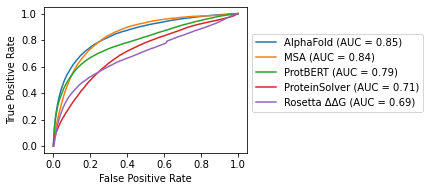

In [23]:
fig, ax = plt.subplots(figsize=(6, 2.5))
for col in score_columns:
    display = RocCurveDisplay.from_predictions(
        df["effect_score"] > 0, df[col], name=labels[col.split("_")[0]], ax=ax
    )
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.55), bbox_transform=ax.transAxes)
fig.subplots_adjust(left=0.09, right=0.56, top=0.98, bottom=0.17)
fig.savefig(NOTEBOOK_DIR.joinpath("unsupervised-auc-curve.svg"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("unsupervised-auc-curve.pdf"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("unsupervised-auc-curve.png"), dpi=300)

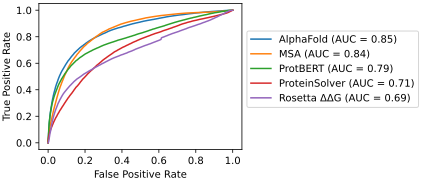

In [24]:
SVG(NOTEBOOK_DIR.joinpath("unsupervised-auc-curve.svg"))

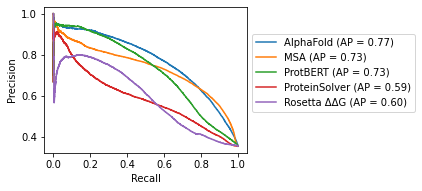

In [25]:
fig, ax = plt.subplots(figsize=(6, 2.5))
for col in score_columns:
    display = PrecisionRecallDisplay.from_predictions(
        df["effect_score"] > 0, df[col], name=labels[col.split("_")[0]], ax=ax
    )
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.55), bbox_transform=ax.transAxes)
fig.subplots_adjust(left=0.09, right=0.56, top=0.98, bottom=0.17)
fig.savefig(NOTEBOOK_DIR.joinpath("unsupervised-pr-curve.svg"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("unsupervised-pr-curve.pdf"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("unsupervised-pr-curve.png"), dpi=300)

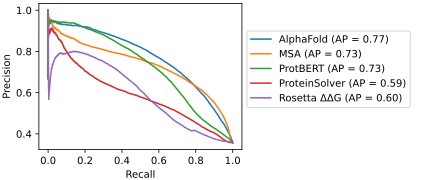

In [26]:
SVG(NOTEBOOK_DIR.joinpath("unsupervised-pr-curve.svg"))

## Cross-validate models

In [27]:
def training_loop(X, y, *, weights, groups, param, n_splits=6, progressbar=False):
    models = []
    preds = np.ones(len(y), dtype=np.float64) * np.nan
    gkf = model_selection.GroupKFold(n_splits=n_splits)
    for train_index, test_index in tqdm(
        gkf.split(X, y, groups=groups),
        total=n_splits,
        disable=not progressbar,
    ):
        X_training, X_testing = X[train_index], X[test_index]
        y_training, y_testing = y[train_index], y[test_index]
        weights_training, weights_testing = weights[train_index], weights[test_index]

        groups_training = groups.iloc[train_index]
        value_counts = groups_training.value_counts()
        group_adj = groups_training.drop_duplicates().map(value_counts)

        dtrain = lgb.Dataset(
            X_training, label=y_training, weight=weights_training, group=group_adj
        )
        model = lgb.train(param, dtrain, num_boost_round=1000)
        preds[test_index] = model.predict(X_testing)
        models.append(model)
    return models, preds

In [28]:
def crossvalidate_models(prediction_df, model_infos, dryrun=False):
    for unique_id, model_type, *_ in tqdm(model_infos):
        scalar_features, vector_features = helpers.load_features(
            NOTEBOOK_DIR.parent,
            unique_id,
        )
        scalar_features = [feature_v1to2_map.get(f, f) for f in scalar_features]
        vector_features = [feature_v1to2_map.get(f, f) for f in vector_features]

        best_features_file = NOTEBOOK_DIR.parent.joinpath(
            "39_cagi6_sherloc_finetune_model", unique_id, "best-parameters.json"
        )
        best_parameters_file = NOTEBOOK_DIR.parent.joinpath(
            "39_cagi6_sherloc_finetune_model", unique_id, "best-features.json"
        )
        if best_parameters_file.is_file():
            with best_features_file.open("rt") as fin:
                best_parameters = json.load(fin)

            with best_parameters_file.open("rt") as fin:
                best_features = json.load(fin)

            training_df, column_group_map, _ = helpers.expand_arrays(
                prediction_df, vector_features
            )
            X = training_df[best_features].values
            del training_df
        else:
            features_to_exclude = helpers.load_features_to_exclude(
                NOTEBOOK_DIR.parent, unique_id, model_type
            )
            best_parameters = helpers.load_best_parameters(
                NOTEBOOK_DIR.parent, unique_id, model_type
            )

            X_ref = np.c_[
                prediction_df[scalar_features].values,
                np.hstack(
                    [np.vstack(prediction_df[col].values) for col in vector_features]
                ),
            ]

            if features_to_exclude is not None:
                feature_mask = np.ones(X_ref.shape[1], dtype=bool)
                feature_mask[np.array(features_to_exclude, dtype=int)] = False
                X = X_ref[:, feature_mask]
                assert len(features_to_exclude) == X_ref.shape[1] - X.shape[1]
            else:
                X = X_ref

        if dryrun:
            continue

        y = (prediction_df["effect_score"] > 0).values.astype(int)

        weights = np.ones(len(prediction_df), dtype=np.float64)
        weights[prediction_df["effect_score"] == 1] = 0.5
        weights[prediction_df["effect_score"] == -1] = 0.5

        protein_ids = prediction_df["protein_id"]

        models, preds = training_loop(
            X,
            y,
            weights=weights,
            groups=protein_ids,
            param=best_parameters | {"objective": "binary", "verbosity": -1},
        )

        pred_column = f"pred_{unique_id}_{model_type}"
        prediction_df[pred_column] = preds
    return prediction_df

In [29]:
def generate_model_stats(df, model_types):
    model_stats = []
    for unique_id, model_type, description in model_types:
        column = f"pred_{unique_id}_{model_type}"
        corr = stats.spearmanr(df["effect_score"], df[column])
        auc = metrics.roc_auc_score(df["effect_score"] > 0, df[column])
        precision = metrics.average_precision_score(df["effect_score"] > 0, df[column])
        model_stats.append((column, len(df), corr[0], auc, precision, description))

    model_stats_df = pd.DataFrame(
        model_stats,
        columns=[
            "column",
            "num_rows",
            "spearman_rho",
            "auc",
            "precision",
            "description",
        ],
    )
    return model_stats_df

### Evaluate new models

In [30]:
model_infos = [
    (
        "e24c2e69",
        "optimized",
        "[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 1",
    )
]

model_infos_df = pd.DataFrame(model_infos, columns=["unique_id", "mode", "description"])
model_infos_df

,unique_id,mode,description
0,e24c2e69,optimized,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 1


In [31]:
features = get_used_features(model_infos_df["unique_id"], set(result_df))
prediction_df = process_results(result_df, features)

Lost 169 rows due to missing features.


In [32]:
prediction_df = crossvalidate_models(prediction_df, model_infos_df.values)

In [33]:
model_stats_df = generate_model_stats(prediction_df, model_infos_df.values)

model_stats_df

,column,num_rows,spearman_rho,auc,precision,description
0,pred_e24c2e69_optimized,84061,0.724232,0.936401,0.891148,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 1


In [34]:
columns_to_compare = [
    ("pred_e24c2e69_optimized", "ELASPIC3 (EL3)"),
    ("el2_score", "ELASPIC2 (EL2)"),
]

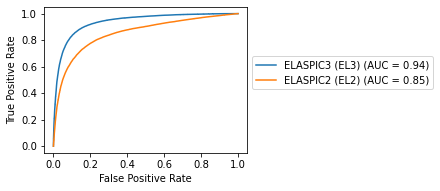

In [35]:
fig, ax = plt.subplots(figsize=(6, 2.5))
for col, label in columns_to_compare:
    display = RocCurveDisplay.from_predictions(
        prediction_df["effect_score"] > 0,
        prediction_df[col],
        name=label,
        ax=ax,
    )
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.55), bbox_transform=ax.transAxes)
fig.subplots_adjust(left=0.09, right=0.56, top=0.98, bottom=0.17)
fig.savefig(NOTEBOOK_DIR.joinpath("el3-vs-el2-auc-curve.svg"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("el3-vs-el2-auc-curve.pdf"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("el3-vs-el2-auc-curve.png"), dpi=300)

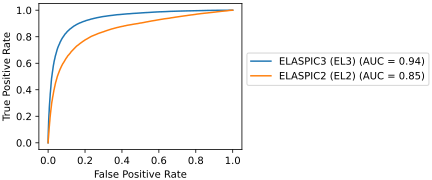

In [36]:
SVG(NOTEBOOK_DIR.joinpath("el3-vs-el2-auc-curve.svg"))

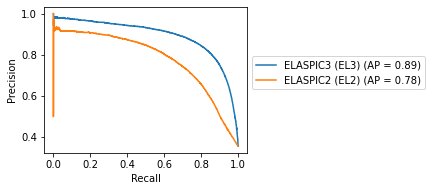

In [37]:
fig, ax = plt.subplots(figsize=(6, 2.5))
for col, label in columns_to_compare:
    display = PrecisionRecallDisplay.from_predictions(
        prediction_df["effect_score"] > 0,
        prediction_df[col],
        name=label,
        ax=ax,
    )
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.55), bbox_transform=ax.transAxes)
fig.subplots_adjust(left=0.09, right=0.56, top=0.98, bottom=0.17)
fig.savefig(NOTEBOOK_DIR.joinpath("el3-vs-el2-pr-curve.svg"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("el3-vs-el2-pr-curve.pdf"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("el3-vs-el2-pr-curve.png"), dpi=300)

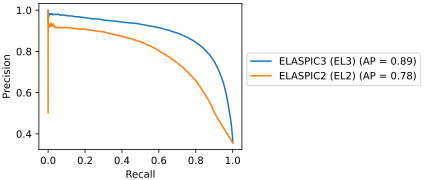

In [38]:
SVG(NOTEBOOK_DIR.joinpath("el3-vs-el2-pr-curve.svg"))

### Supervised performance

In [39]:
model_infos = [
    ("fd274a14", "optimized", "[]", "Base",),
    ("7172eff2", "optimized", "[msa]", "MSA statistics"),
    ("86b64df1", "optimized", "[proteinsolver]", "ProteinSolver"),
    ("40bd478e", "optimized", "[protbert]", "ProtBERT"),
    ("35ced672", "optimized", "[rosetta_ddg]"),
    ("371f203b", "optimized", "[alphafold]"),
]

model_infos_df = pd.DataFrame(model_infos, columns=["unique_id", "mode", "description"])
model_infos_df

,unique_id,mode,description
0,fd274a14,optimized,[]
1,7172eff2,optimized,[msa]
2,86b64df1,optimized,[proteinsolver]
3,40bd478e,optimized,[protbert]
4,35ced672,optimized,[rosetta_ddg]
5,371f203b,optimized,[alphafold]


In [40]:
features = get_used_features(model_infos_df["unique_id"], set(result_df))
prediction_df = process_results(result_df, features)

Lost 169 rows due to missing features.


In [41]:
prediction_df = crossvalidate_models(prediction_df, model_infos_df.values)

In [42]:
model_stats_df = generate_model_stats(prediction_df, model_infos_df.values)

In [43]:
model_stats_df.sort_values("precision", ascending=False)

,column,num_rows,spearman_rho,auc,precision,description
0,pred_e24c2e69_optimized,84061,0.724232,0.936401,0.891148,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 1


In [ ]:
print(model_stats_df.to_csv(index=False))

In [ ]:
description_label_map = {
    "": "Base",
    "msa": "MSA statistics",
    "proteinsolver": "ProteinSolver",
    "protbert": "ProtBERT",
    "rosetta_ddg": "Rosetta ΔΔG",
    "alphafold": "AlphaFold",
}

columns_to_compare = [
    (f"pred_{unique_id}_optimized", description_label_map[description.strip("[]")])
    for unique_id, _, description in model_infos_df.values
]

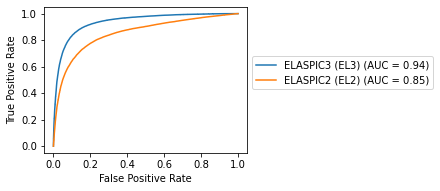

In [35]:
fig, ax = plt.subplots(figsize=(6, 2.5))
for col, label in columns_to_compare:
    display = RocCurveDisplay.from_predictions(
        prediction_df["effect_score"] > 0,
        prediction_df[col],
        name=label,
        ax=ax,
    )
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.55), bbox_transform=ax.transAxes)
fig.subplots_adjust(left=0.09, right=0.56, top=0.98, bottom=0.17)
fig.savefig(NOTEBOOK_DIR.joinpath("supervised-auc-curve.svg"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("supervised-auc-curve.pdf"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("supervised-auc-curve.png"), dpi=300)

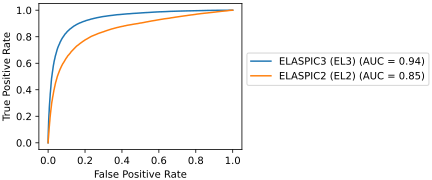

In [36]:
SVG(NOTEBOOK_DIR.joinpath("supervised-auc-curve.svg"))

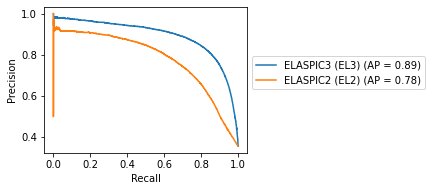

In [37]:
fig, ax = plt.subplots(figsize=(6, 2.5))
for col, label in columns_to_compare:
    display = PrecisionRecallDisplay.from_predictions(
        prediction_df["effect_score"] > 0,
        prediction_df[col],
        name=label,
        ax=ax,
    )
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.55), bbox_transform=ax.transAxes)
fig.subplots_adjust(left=0.09, right=0.56, top=0.98, bottom=0.17)
fig.savefig(NOTEBOOK_DIR.joinpath("supervised-pr-curve.svg"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("supervised-pr-curve.pdf"), dpi=300)
fig.savefig(NOTEBOOK_DIR.joinpath("supervised-pr-curve.png"), dpi=300)

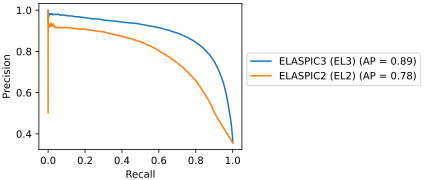

In [38]:
SVG(NOTEBOOK_DIR.joinpath("supervised-pr-curve.svg"))

### Ablation experiments

In [45]:
model_infos = [
    (
        "77dd627f",
        "optimized",
        "[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 3",
    ),
    ("7f2ea4f1", "optimized", "[proteinsolver-protbert-rosetta_ddg-alphafold]"),
    ("1bea3f9b", "optimized", "[msa-protbert-rosetta_ddg-alphafold]"),
    ("37046b91", "optimized", "[msa-proteinsolver-rosetta_ddg-alphafold]"),
    ("848d5147", "optimized", "[msa-proteinsolver-protbert-rosetta_ddg]"),
    ("b81e162b", "optimized", "[msa-proteinsolver-protbert-alphafold]"),
]

model_infos_df = pd.DataFrame(model_infos, columns=["unique_id", "mode", "description"])
model_infos_df

,unique_id,mode,description
0,77dd627f,optimized,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 3
1,7f2ea4f1,optimized,[proteinsolver-protbert-rosetta_ddg-alphafold]
2,1bea3f9b,optimized,[msa-protbert-rosetta_ddg-alphafold]
3,37046b91,optimized,[msa-proteinsolver-rosetta_ddg-alphafold]
4,848d5147,optimized,[msa-proteinsolver-protbert-rosetta_ddg]
5,b81e162b,optimized,[msa-proteinsolver-protbert-alphafold]


In [46]:
features = get_used_features(model_infos_df["unique_id"], set(result_df))
prediction_df = process_results(result_df, features)

Lost 169 rows due to missing features.


In [47]:
prediction_df = crossvalidate_models(prediction_df, model_infos_df.values)

In [48]:
model_stats_df = generate_model_stats(prediction_df, model_infos_df.values)

KeyError: 'pred_77dd627f_optimized'

In [ ]:
model_stats_df.sort_values("precision", ascending=False)

In [ ]:
print(model_stats_df.to_csv(index=False))

In [ ]:
description_label_map = {
    "": "Base",
    "msa": "MSA statistics",
    "proteinsolver": "ProteinSolver",
    "protbert": "ProtBERT",
    "rosetta_ddg": "Rosetta ΔΔG",
    "alphafold": "AlphaFold",
}

columns_to_compare = [
    (f"pred_{unique_id}_optimized", description_label_map[description.strip("[]")])
    for unique_id, _, description in model_infos_df.values
]

### Final model performance

In [80]:
model_infos = [
    # === New AlphaFold features ===
    (
        "e24c2e69",
        "optimized",
        "[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 1",
    ),  # (536, 0.05860861234359211, 0.5353153916581976, 0.38425470096564085, 1)
    (
        "e38ce536",
        "optimized",
        "[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 2",
    ),  # (658, 0.037668511078108584, 0.5226976744712064, 0.3654045714144351, 1)
    (
        "77dd627f",
        "optimized",
        "[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 3",
    ),  # (820, 0.07124869204990739, 0.5429318313964044, 0.37883621098619236, 1)
    (
        "cfc8a52c",
        "optimized",
        "[msa-proteinsolver-protbert-rosetta_ddg-alphafold] FE on humsavar",
    ),
    #
    # === Old AlphaFold features
    ("7f9826be", "optimized", "† [AFwt + everything else]"),
    ("fd28687b", "optimized", "[AFwt + everything else]"),
]

model_infos_df = pd.DataFrame(model_infos, columns=["unique_id", "mode", "description"])
model_infos_df

,unique_id,mode,description
0,e24c2e69,optimized,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 1
1,e38ce536,optimized,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 2
2,77dd627f,optimized,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 3
3,cfc8a52c,optimized,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] FE on humsavar
4,7f9826be,optimized,† `base` + `AFwt
5,fd28687b,optimized,`base` + `AFwt`


In [81]:
features = get_used_features(model_infos_df["unique_id"], set(result_df))
prediction_df = process_results(result_df, features)

Could not map all features for model 7f9826be.
{'alphafold_core_score_protein_ptm'}
Could not map all features for model fd28687b.
{'alphafold_core_score_protein_ptm'}
Lost 169 rows due to missing features.


In [82]:
prediction_df = crossvalidate_models(prediction_df, model_infos_df.values)

In [84]:
model_stats_df = generate_model_stats(prediction_df, model_infos_df.values)

model_stats_df

,column,num_rows,spearman_rho,auc,precision,description
0,pred_e24c2e69_optimized,84061,0.724123,0.936335,0.890893,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 1
1,pred_e38ce536_optimized,84061,0.722587,0.935410,0.889996,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 2
2,pred_77dd627f_optimized,84061,0.723547,0.935988,0.890639,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 3
3,pred_cfc8a52c_optimized,84061,0.723409,0.935905,0.890131,[msa-proteinsolver-protbert-rosetta_ddg-alphafold] FE on humsavar
4,pred_7f9826be_optimized,84061,0.712026,0.929045,0.879196,† `base` + `AFwt
5,pred_fd28687b_optimized,84061,0.709841,0.927729,0.877164,`base` + `AFwt`


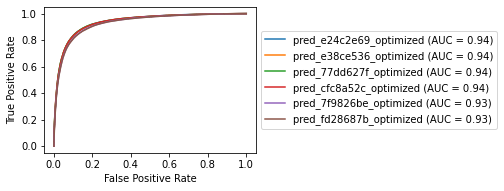

In [88]:
fig, ax = plt.subplots(figsize=(6, 2.5))
for col in model_stats_df["column"]:
    display = RocCurveDisplay.from_predictions(
        prediction_df["effect_score"] > 0,
        prediction_df[col],
        name=col,
        ax=ax,
    )
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), bbox_transform=ax.transAxes)
fig.subplots_adjust(left=0.09, right=0.58, top=0.98, bottom=0.17)


## Other

In [ ]:
model_infos = [
    # === New AlphaFold features ===
    (
        "e24c2e69",
        "optimized",
        "[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 1",
    ),  # (536, 0.05860861234359211, 0.5353153916581976, 0.38425470096564085, 1)
    (
        "e38ce536",
        "optimized",
        "[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 2",
    ),  # (658, 0.037668511078108584, 0.5226976744712064, 0.3654045714144351, 1)
    (
        "77dd627f",
        "optimized",
        "[msa-proteinsolver-protbert-rosetta_ddg-alphafold] Try 3",
    ),  # (820, 0.07124869204990739, 0.5429318313964044, 0.37883621098619236, 1)
    (
        "cfc8a52c",
        "optimized",
        "[msa-proteinsolver-protbert-rosetta_ddg-alphafold] FE on humsavar",
    ),
    #
    ("fd274a14", "optimized", "[]"),
    ("7172eff2", "optimized", "[msa]"),
    ("86b64df1", "optimized", "[proteinsolver]"),
    ("40bd478e", "optimized", "[protbert]"),
    ("35ced672", "optimized", "[rosetta_ddg]"),
    ("371f203b", "optimized", "[alphafold]"),
    ("1bea3f9b", "optimized", "[msa-protbert-rosetta_ddg-alphafold]"),
    ("37046b91", "optimized", "[msa-proteinsolver-rosetta_ddg-alphafold]"),
    ("848d5147", "optimized", "[msa-proteinsolver-protbert-rosetta_ddg]"),
    ("b81e162b", "optimized", "[msa-proteinsolver-protbert-alphafold]"),
    #
    #
    # === Old AlphaFold features ===
    (
        "6d02ae59",
        "optimized",
        "proteinsolver-protbert-rosetta_ddg-alphafold_wt",
    ),
    # (
    #     "b2d0dfb9",
    #     "optimized",
    #     "proteinsolver-protbert-rosetta_ddg-alphafold_wt-alphafold_change",
    # ),  # AFchange
    ("1855e7a4", "optimized", "proteinsolver"),
    ("a6b35daa", "optimized", "protbert"),
    ("2cf623ec", "optimized", "rosetta_ddg"),
    ("bfda8ca8", "optimized", "alphafold_wt"),
    # ("b93fddbb", "optimized", "alphafold_change"),  # AFchange
    #
    #
    # `base` + `AFwt`
    #     ("7f9826be", "initial", "† `base` + `AFwt"),
    ("7f9826be", "optimized", "† `base` + `AFwt"),
    #
    # `base` + `AFwt`
    #     ("fd28687b", "initial", "`base` + `AFwt`"),
    ("fd28687b", "optimized", "`base` + `AFwt`"),
    #
    # `base` + `AFwt` + `AFmut`
    #     ("900500fe", "initial", "† `base` + `AFwt` + `AFmut`"),
    # * ("900500fe", "optimized", "† `base` + `AFwt` + `AFmut"),
    #
    # `base` + `AFwt` + `AFmut`
    #     ("be3bdad5", "initial", "base` + `AFwt` + `AFmut"),
    # * ("be3bdad5", "optimized", "base` + `AFwt` + `AFmut"),
    #
    #
    #
    #
    #
    #     # `base` + `EL2` + `AFwt`
    #     #     ("6999e5aa", "initial"),
    #     ("6999e5aa", "optimized"),
    #     # `base` + `EL2` + `AFwt` + `AFmut` [no opt]
    #     #     ("4df6fd79", "initial"),
    #     # `base`
    #     #     ("0d59c727", "initial"),
    #     ("0d59c727", "optimized"),
    #     # `base - rosetta`
    #     #     ("eabf01fe", "initial"),
    #     ("eabf01fe", "optimized"),
    #     # `base - rosetta - ps`
    #     ("a7b1c747", "optimized"),
]

In [50]:
# No AFchange features
text = """\
col,num_rows,spearman_rho,auc,precision,description
pred_e24c2e69_optimized,84061,0.7241229950764732,0.9363349963054279,0.8908933806863095,msa-proteinsolver-protbert-rosetta_ddg-alphafold (Try 1)
pred_cfc8a52c_optimized,84061,0.7234091655744261,0.9359048638621051,0.8901313808148839,msa-proteinsolver-protbert-rosetta_ddg-alphafold (Feature elimination on humsavar only)
pred_7172eff2_optimized,84096,0.6215280006410547,0.8745156629925883,0.7977451777232469,msa
"""

buf = io.StringIO()
buf.write(text)
buf.seek(0)
df = pd.read_csv(buf)

df

,col,num_rows,spearman_rho,auc,precision,description
0,pred_e24c2e69_optimized,84061,0.724123,0.936335,0.890893,msa-proteinsolver-protbert-rosetta_ddg-alphafold (Try 1)
1,pred_cfc8a52c_optimized,84061,0.723409,0.935905,0.890131,msa-proteinsolver-protbert-rosetta_ddg-alphafold (Feature elimination on humsavar only)
2,pred_7172eff2_optimized,84096,0.621528,0.874516,0.797745,msa


In [51]:
# No AFchange features
text = """\
col,num_rows,spearman_rho,auc,precision,description
pred_e24c2e69_optimized,84061,0.7241229950764732,0.9363349963054279,0.8908933806863095,msa-proteinsolver-protbert-rosetta_ddg-alphafold (Try 1)
pred_cfc8a52c_optimized,84061,0.7234091655744261,0.9359048638621051,0.8901313808148839,msa-proteinsolver-protbert-rosetta_ddg-alphafold (Feature elimination on humsavar only)
pred_7f9826be_optimized,84061,0.7120255977822328,0.9290454642237541,0.8791960794256398,† `base` + `AFwt
pred_6d02ae59_optimized,84061,0.7117045908815401,0.9288520350055411,0.878702640564995,proteinsolver-protbert-rosetta_ddg-alphafold_wt
pred_fd28687b_optimized,84061,0.7098409160938216,0.9277290399658271,0.877163555566274,`base` + `AFwt`
pred_bfda8ca8_optimized,84061,0.7026476963538095,0.9233946195282239,0.8705023918921035,alphafold_wt
pred_2cf623ec_optimized,84061,0.672575440907151,0.9052739721272776,0.8453596554777921,rosetta_ddg
pred_a6b35daa_optimized,84061,0.6732798008591453,0.905698398501154,0.8448287934251786,protbert
pred_1855e7a4_optimized,84061,0.6601976583600879,0.8978154882251447,0.8326422727851135,proteinsolver
"""

buf = io.StringIO()
buf.write(text)
buf.seek(0)
df = pd.read_csv(buf)

df

,col,num_rows,spearman_rho,auc,precision,description
0,pred_e24c2e69_optimized,84061,0.724123,0.936335,0.890893,msa-proteinsolver-protbert-rosetta_ddg-alphafold (Try 1)
1,pred_cfc8a52c_optimized,84061,0.723409,0.935905,0.890131,msa-proteinsolver-protbert-rosetta_ddg-alphafold (Feature elimination on humsavar only)
2,pred_7f9826be_optimized,84061,0.712026,0.929045,0.879196,† `base` + `AFwt
3,pred_6d02ae59_optimized,84061,0.711705,0.928852,0.878703,proteinsolver-protbert-rosetta_ddg-alphafold_wt
4,pred_fd28687b_optimized,84061,0.709841,0.927729,0.877164,`base` + `AFwt`
5,pred_bfda8ca8_optimized,84061,0.702648,0.923395,0.870502,alphafold_wt
6,pred_2cf623ec_optimized,84061,0.672575,0.905274,0.845360,rosetta_ddg
7,pred_a6b35daa_optimized,84061,0.673280,0.905698,0.844829,protbert
8,pred_1855e7a4_optimized,84061,0.660198,0.897815,0.832642,proteinsolver


## Explore previous results

In [28]:
# No AFchange features
text = """\
col,num_rows,spearman_rho,auc,precision,description
pred_6d02ae59_optimized,81595,0.7126101934569414,0.9302800089637497,0.880811545138274,proteinsolver-protbert-rosetta_ddg-alphafold_wt
pred_7f9826be_optimized,81595,0.7124691243200059,0.9301948302362175,0.880199093804648,† `base` + `AFwt
pred_fd28687b_optimized,81595,0.7114664224991962,0.9295893904706803,0.8794599027426224,`base` + `AFwt
pred_bfda8ca8_optimized,81595,0.7030689431700953,0.9245189220506452,0.872121834543896,alphafold_wt
pred_a6b35daa_optimized,81595,0.6743788270565445,0.9071955894191768,0.845464460517332,protbert
pred_2cf623ec_optimized,81595,0.6717861214568219,0.9056300920422187,0.8439723991520722,rosetta_ddg
pred_1855e7a4_optimized,81595,0.6589128014374122,0.8978570734912574,0.8329363544743443,proteinsolver
"""

buf = io.StringIO()
buf.write(text)
buf.seek(0)
df = pd.read_csv(buf)

df

,col,num_rows,spearman_rho,auc,precision,description
0,pred_6d02ae59_optimized,81595,0.712610,0.930280,0.880812,proteinsolver-protbert-rosetta_ddg-alphafold_wt
1,pred_7f9826be_optimized,81595,0.712469,0.930195,0.880199,† `base` + `AFwt
2,pred_fd28687b_optimized,81595,0.711466,0.929589,0.879460,`base` + `AFwt
3,pred_bfda8ca8_optimized,81595,0.703069,0.924519,0.872122,alphafold_wt
4,pred_a6b35daa_optimized,81595,0.674379,0.907196,0.845464,protbert
5,pred_2cf623ec_optimized,81595,0.671786,0.905630,0.843972,rosetta_ddg
6,pred_1855e7a4_optimized,81595,0.658913,0.897857,0.832936,proteinsolver


In [29]:
# With AFchange features
text = """\
col,num_rows,spearman_rho,auc,precision,description
pred_900500fe_optimized,17253,0.7354856043327243,0.9482191810766243,0.9064460127045698,† `base` + `AFwt` + `AFmut
pred_b2d0dfb9_optimized,17253,0.7346465855388026,0.947707866763327,0.9059681098917662,proteinsolver-protbert-rosetta_ddg-alphafold_wt-alphafold_change
pred_be3bdad5_optimized,17253,0.7345652166112319,0.9476582789619261,0.9056403859073822,base` + `AFwt` + `AFmut
pred_fd28687b_optimized,17253,0.732317473690829,0.9462884608647142,0.9026205233330327,`base` + `AFwt
pred_7f9826be_optimized,17253,0.7299587820757071,0.944851028482742,0.9006481903084101,† `base` + `AFwt
pred_6d02ae59_optimized,17253,0.7281784682664034,0.9437660707446643,0.8992294897475985,proteinsolver-protbert-rosetta_ddg-alphafold_wt
pred_bfda8ca8_optimized,17253,0.7148309423466335,0.9356318297389664,0.8868176529446166,alphafold_wt
pred_a6b35daa_optimized,17253,0.6985532259113003,0.9257118739128337,0.8728662959252519,protbert
pred_b93fddbb_optimized,17253,0.6990239962585558,0.9259987704860353,0.8714278272872622,alphafold_change
pred_2cf623ec_optimized,17253,0.6817438107602027,0.9154678905510983,0.8555810561252877,rosetta_ddg
pred_1855e7a4_optimized,17253,0.6741823722269124,0.9108598033675988,0.8479407023908969,proteinsolver
"""

buf = io.StringIO()
buf.write(text)
buf.seek(0)
df = pd.read_csv(buf)

df

,col,num_rows,spearman_rho,auc,precision,description
0,pred_900500fe_optimized,17253,0.735486,0.948219,0.906446,† `base` + `AFwt` + `AFmut
1,pred_b2d0dfb9_optimized,17253,0.734647,0.947708,0.905968,proteinsolver-protbert-rosetta_ddg-alphafold_w...
2,pred_be3bdad5_optimized,17253,0.734565,0.947658,0.905640,base` + `AFwt` + `AFmut
3,pred_fd28687b_optimized,17253,0.732317,0.946288,0.902621,`base` + `AFwt
4,pred_7f9826be_optimized,17253,0.729959,0.944851,0.900648,† `base` + `AFwt
5,pred_6d02ae59_optimized,17253,0.728178,0.943766,0.899229,proteinsolver-protbert-rosetta_ddg-alphafold_wt
6,pred_bfda8ca8_optimized,17253,0.714831,0.935632,0.886818,alphafold_wt
7,pred_a6b35daa_optimized,17253,0.698553,0.925712,0.872866,protbert
8,pred_b93fddbb_optimized,17253,0.699024,0.925999,0.871428,alphafold_change
9,pred_2cf623ec_optimized,17253,0.681744,0.915468,0.855581,rosetta_ddg


In [30]:
# Feature importance plot
text = """\
col,num_rows,spearman_rho,auc,precision,description
pred_b2d0dfb9_optimized,17253,0.6601727571431505,0.9481965731116135,0.9067716066327483,proteinsolver-protbert-rosetta_ddg-alphafold_wt-alphafold_change
pred_900500fe_optimized,17253,0.6612351121473227,0.9481366245739297,0.9066021792716579,† `base` + `AFwt` + `AFmut
pred_be3bdad5_optimized,17253,0.6602745245026902,0.9481329563941763,0.9059602464731495,base` + `AFwt` + `AFmut
pred_fd28687b_optimized,17253,0.66006825770403,0.9468243894127648,0.9030312955646863,`base` + `AFwt
pred_7f9826be_optimized,17253,0.6570532178203087,0.9449691139264764,0.9007917435348626,† `base` + `AFwt
pred_6d02ae59_optimized,17253,0.6573581105157068,0.9442761423684942,0.9001343322979737,proteinsolver-protbert-rosetta_ddg-alphafold_wt
pred_bfda8ca8_optimized,17253,0.6429108664472806,0.9352726325942174,0.885861339727888,alphafold_wt
pred_a6b35daa_optimized,17253,0.620116936734454,0.9253679932900758,0.8727568045746302,protbert
pred_b93fddbb_optimized,17253,0.6274405849607265,0.9261415450253343,0.8711723520642649,alphafold_change
pred_2cf623ec_optimized,17253,0.6081952728908755,0.9155725010488,0.8573706009222684,rosetta_ddg
pred_1855e7a4_optimized,17253,0.6030478406891615,0.9100577895518862,0.8478961125297617,proteinsolver
"""

buf = io.StringIO()
buf.write(text)
buf.seek(0)
df = pd.read_csv(buf)

df

,col,num_rows,spearman_rho,auc,precision,description
0,pred_b2d0dfb9_optimized,17253,0.660173,0.948197,0.906772,proteinsolver-protbert-rosetta_ddg-alphafold_w...
1,pred_900500fe_optimized,17253,0.661235,0.948137,0.906602,† `base` + `AFwt` + `AFmut
2,pred_be3bdad5_optimized,17253,0.660275,0.948133,0.905960,base` + `AFwt` + `AFmut
3,pred_fd28687b_optimized,17253,0.660068,0.946824,0.903031,`base` + `AFwt
4,pred_7f9826be_optimized,17253,0.657053,0.944969,0.900792,† `base` + `AFwt
5,pred_6d02ae59_optimized,17253,0.657358,0.944276,0.900134,proteinsolver-protbert-rosetta_ddg-alphafold_wt
6,pred_bfda8ca8_optimized,17253,0.642911,0.935273,0.885861,alphafold_wt
7,pred_a6b35daa_optimized,17253,0.620117,0.925368,0.872757,protbert
8,pred_b93fddbb_optimized,17253,0.627441,0.926142,0.871172,alphafold_change
9,pred_2cf623ec_optimized,17253,0.608195,0.915573,0.857371,rosetta_ddg
